# Cropping sattelite images to smaller pieces

- Load dataframe from pickle
- Crop all sat images to the same resolution
- Crop sat images into smaller pieces using sliding window
- Convert to numpy array
- Save to file using pickle

In [ ]:
RELOAD_DATAFRAME = True # set to true if you want to reload the dataset from pickle file 
PLOT = True # if you want to plot images set to True

# Load dataset from pickle to dataframe 

In [ ]:
if RELOAD_DATAFRAME:
    import pickle

    with open(r"dataset/kaggle/challenge8_dataset.pickle", "rb") as input_file:
        df_ch8_dataset = pickle.load(input_file)

# Set constants
### !!!Be sure to use the same values for step3 notebook!!!

In [35]:
SAT_IMG_SIZE = 3200 # to simplify cropping I'm first cropping all the sat images to the same resolution 3200x3200
IMG_SIZE = 400 # 160, 400 or 800? default 400
OVERLAPING_CROPS = True # True/False
if OVERLAPING_CROPS:
    STEP = IMG_SIZE//2
    DATASET_X_NAME = "X_%s_overlap.npy" % (IMG_SIZE)
    DATASET_Y_NAME = "Y_%s_overlap.npy" % (IMG_SIZE)
else:
    STEP = IMG_SIZE
    DATASET_X_NAME = "X_%s.npy" % (IMG_SIZE)
    DATASET_Y_NAME = "Y_%s.npy" % (IMG_SIZE)

# Convert all images and masks to numpy arrays and crop them to single square size

In [21]:
import numpy as np

images_np = np.array(df_ch8_dataset.img_data.values)
masks_np = np.array(df_ch8_dataset.mask_data.values)


In [22]:
images_np_cropped = images_np
masks_np_cropped = masks_np

In [23]:
SAT_IMG_COUNT = images_np_cropped.shape[0]

In [24]:
crop_coords = (0, 0, SAT_IMG_SIZE, SAT_IMG_SIZE)

In [25]:
from PIL import Image

for i in range(0, SAT_IMG_COUNT):
    images_np_cropped[i] = np.array(Image.fromarray(images_np[i]).crop(crop_coords))
    masks_np_cropped[i] = np.array(Image.fromarray(masks_np[i]).crop(crop_coords))

In [26]:
images_np_cropped = np.stack(images_np_cropped)
masks_np_cropped = np.stack(masks_np_cropped)

# Visualize images

In [ ]:
if PLOT:
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig, axes = plt.subplots(SAT_IMG_COUNT, 2, figsize=(2*10, SAT_IMG_COUNT*10))
    jj = 0
    for m in range(0, SAT_IMG_COUNT):
        axes[m, 0].imshow(images_np_cropped[jj])
        axes[m, 1].imshow(masks_np_cropped[jj], cmap="gray")
        jj += 1

# Get rid of fully black masks

In [27]:
to_delete = []
for i in range(0, SAT_IMG_COUNT):
    if masks_np_cropped[i].sum() == 0:
        to_delete.append(i)
to_delete

[16, 21]

In [28]:
masks_np_cropped = np.delete(masks_np_cropped, to_delete, axis=0)
images_np_cropped = np.delete(images_np_cropped, to_delete, axis=0)

In [29]:
SAT_IMG_COUNT = images_np_cropped.shape[0]
SAT_IMG_COUNT

23

# Visualize sat images after removing fully black ones

In [ ]:
if PLOT:
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig, axes = plt.subplots(SAT_IMG_COUNT, 2, figsize=(2*10, SAT_IMG_COUNT*10))
    jj = 0
    for m in range(0, SAT_IMG_COUNT):
        axes[m, 0].imshow(images_np_cropped[jj])
        axes[m, 1].imshow(masks_np_cropped[jj], cmap="gray")
        jj += 1

# Cut sat images and masks into smaller images
Using sliding window for that

In [30]:
i_max = SAT_IMG_SIZE // STEP - int(OVERLAPING_CROPS) # if overlapping then remote 1 image since it wont fit fully
print('i_max = %s' % i_max)

i_max = 15


In [31]:
j_max = SAT_IMG_COUNT
print('j_max = %s' % j_max)

j_max = 23


In [32]:
arr_img = np.zeros((j_max*i_max*i_max, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
arr_mask = np.zeros((j_max*i_max*i_max, IMG_SIZE, IMG_SIZE), dtype=np.uint8)

k = 0 # index in final array

for j in range(0, j_max):  
    im_tmp = Image.fromarray(images_np_cropped[j])
    mask_tmp = Image.fromarray(masks_np_cropped[j])
    for row in range(0, i_max):
        for col in range(0, i_max):
            crop_coords = (col*(STEP), row*(STEP), col*(STEP)+IMG_SIZE, row*(STEP)+IMG_SIZE)
            arr_img[k] = np.array(im_tmp.crop(crop_coords), dtype=np.uint8)
            arr_mask[k] = np.array(mask_tmp.crop(crop_coords), dtype=np.uint8)
            k += 1
            
print('x =', arr_img.shape)
print('y =', arr_mask.shape)

x = (5175, 400, 400, 3)
y = (5175, 400, 400)


# Visualize all the small crops from a single sat image

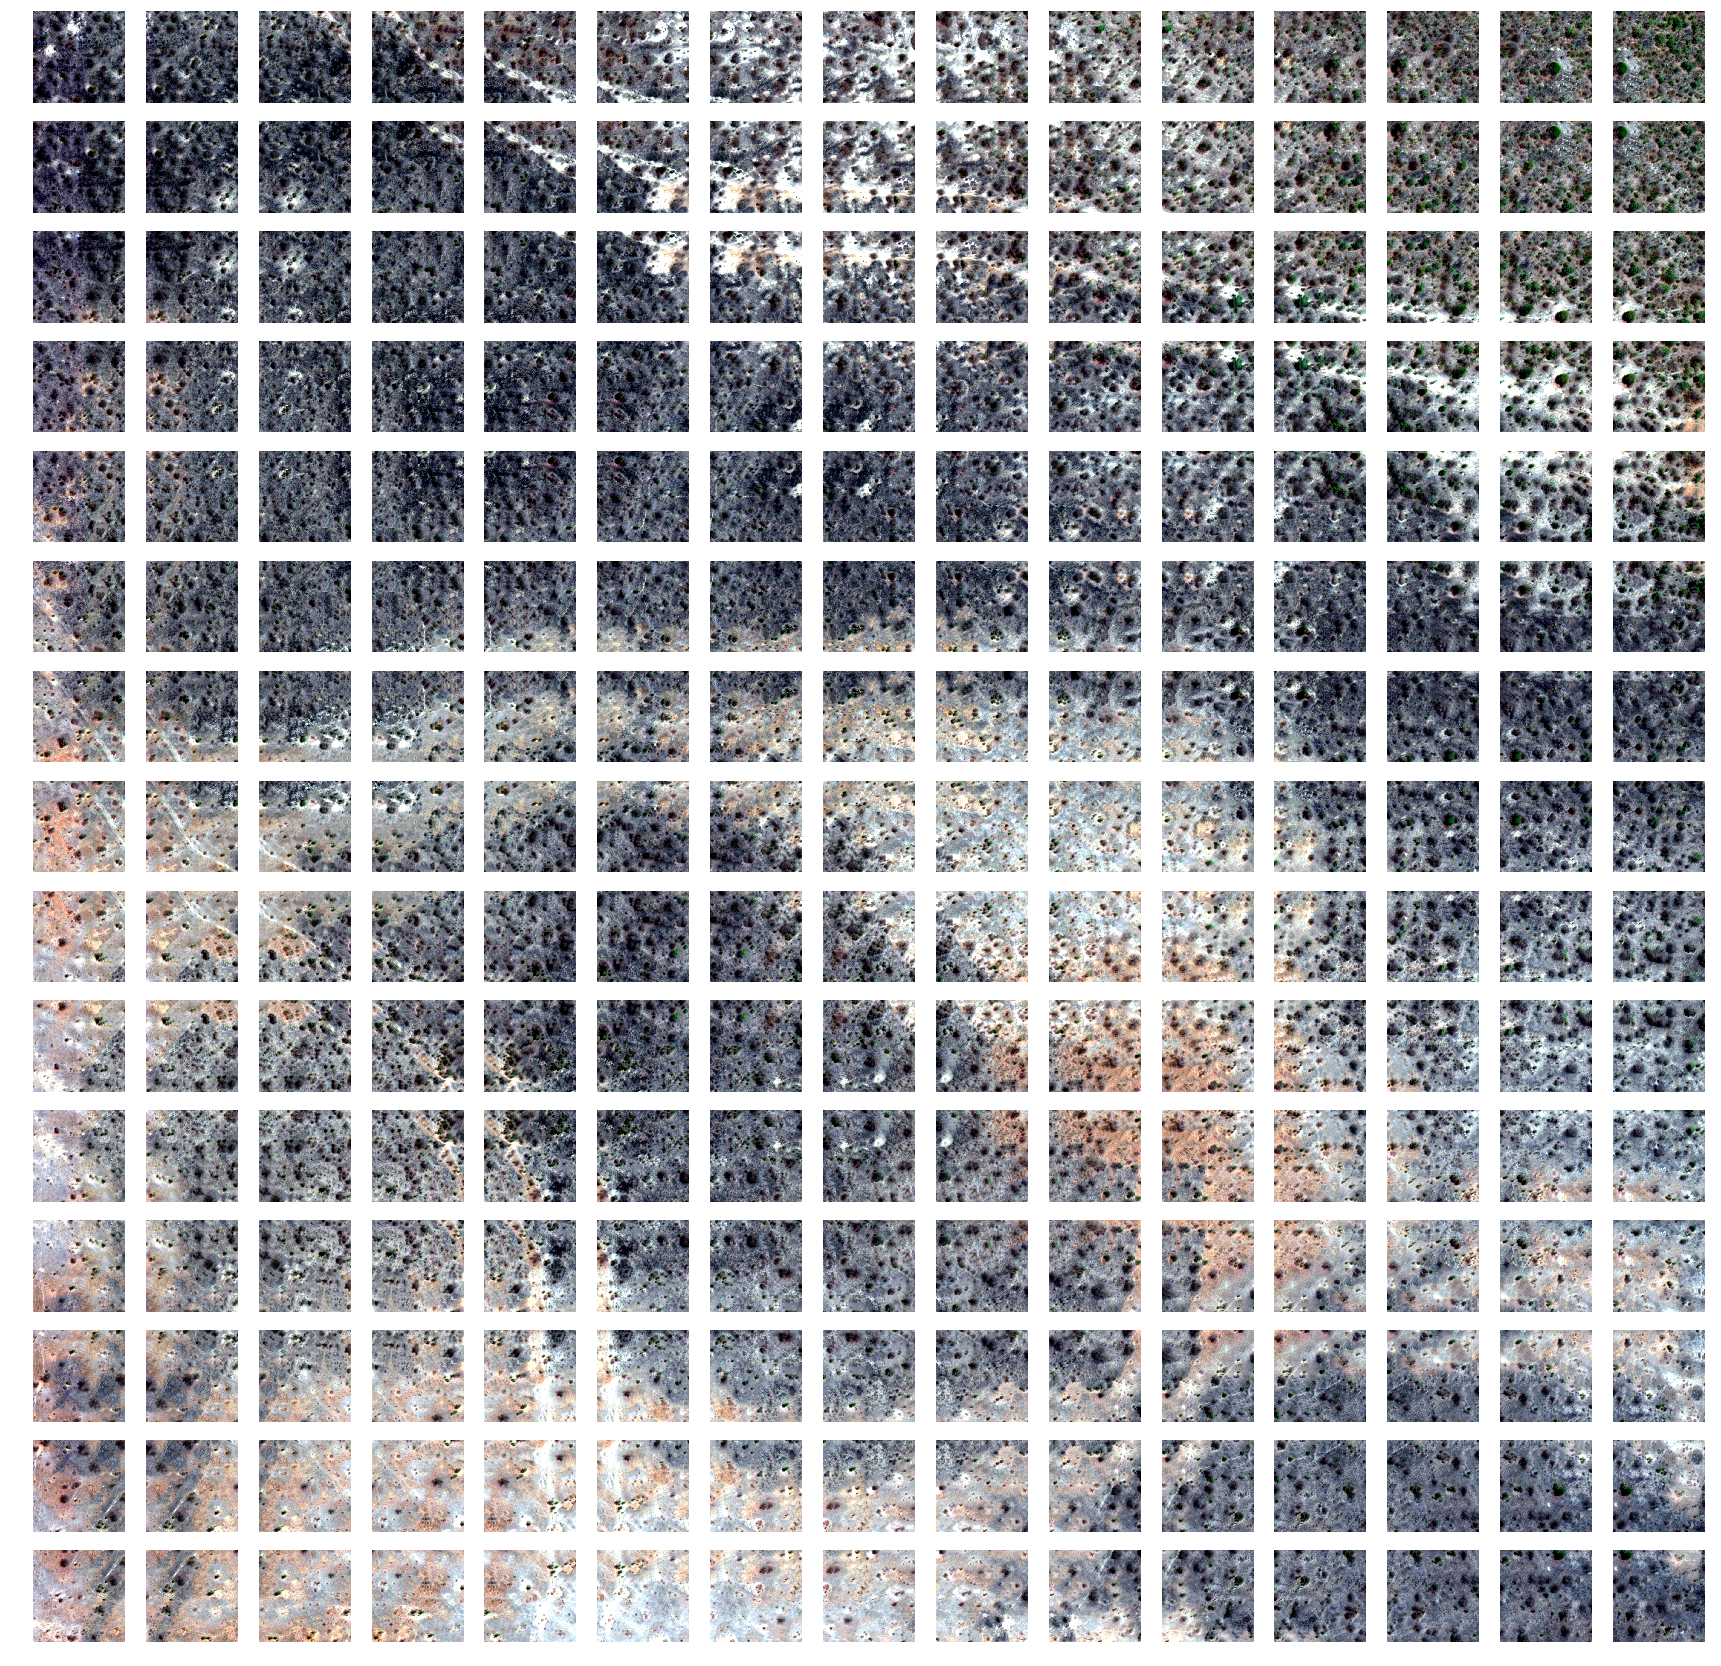

In [33]:
if PLOT:
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig, axes = plt.subplots(i_max, i_max, figsize=(i_max*2, i_max*2))
    jj = 0
    for i in range(0, i_max):
        for j in range(0, i_max):
            axes[i, j].imshow(arr_img[jj])
            axes[i, j].set_axis_off()
            jj += 1

# Visualize all the small crops from a single sat image mask

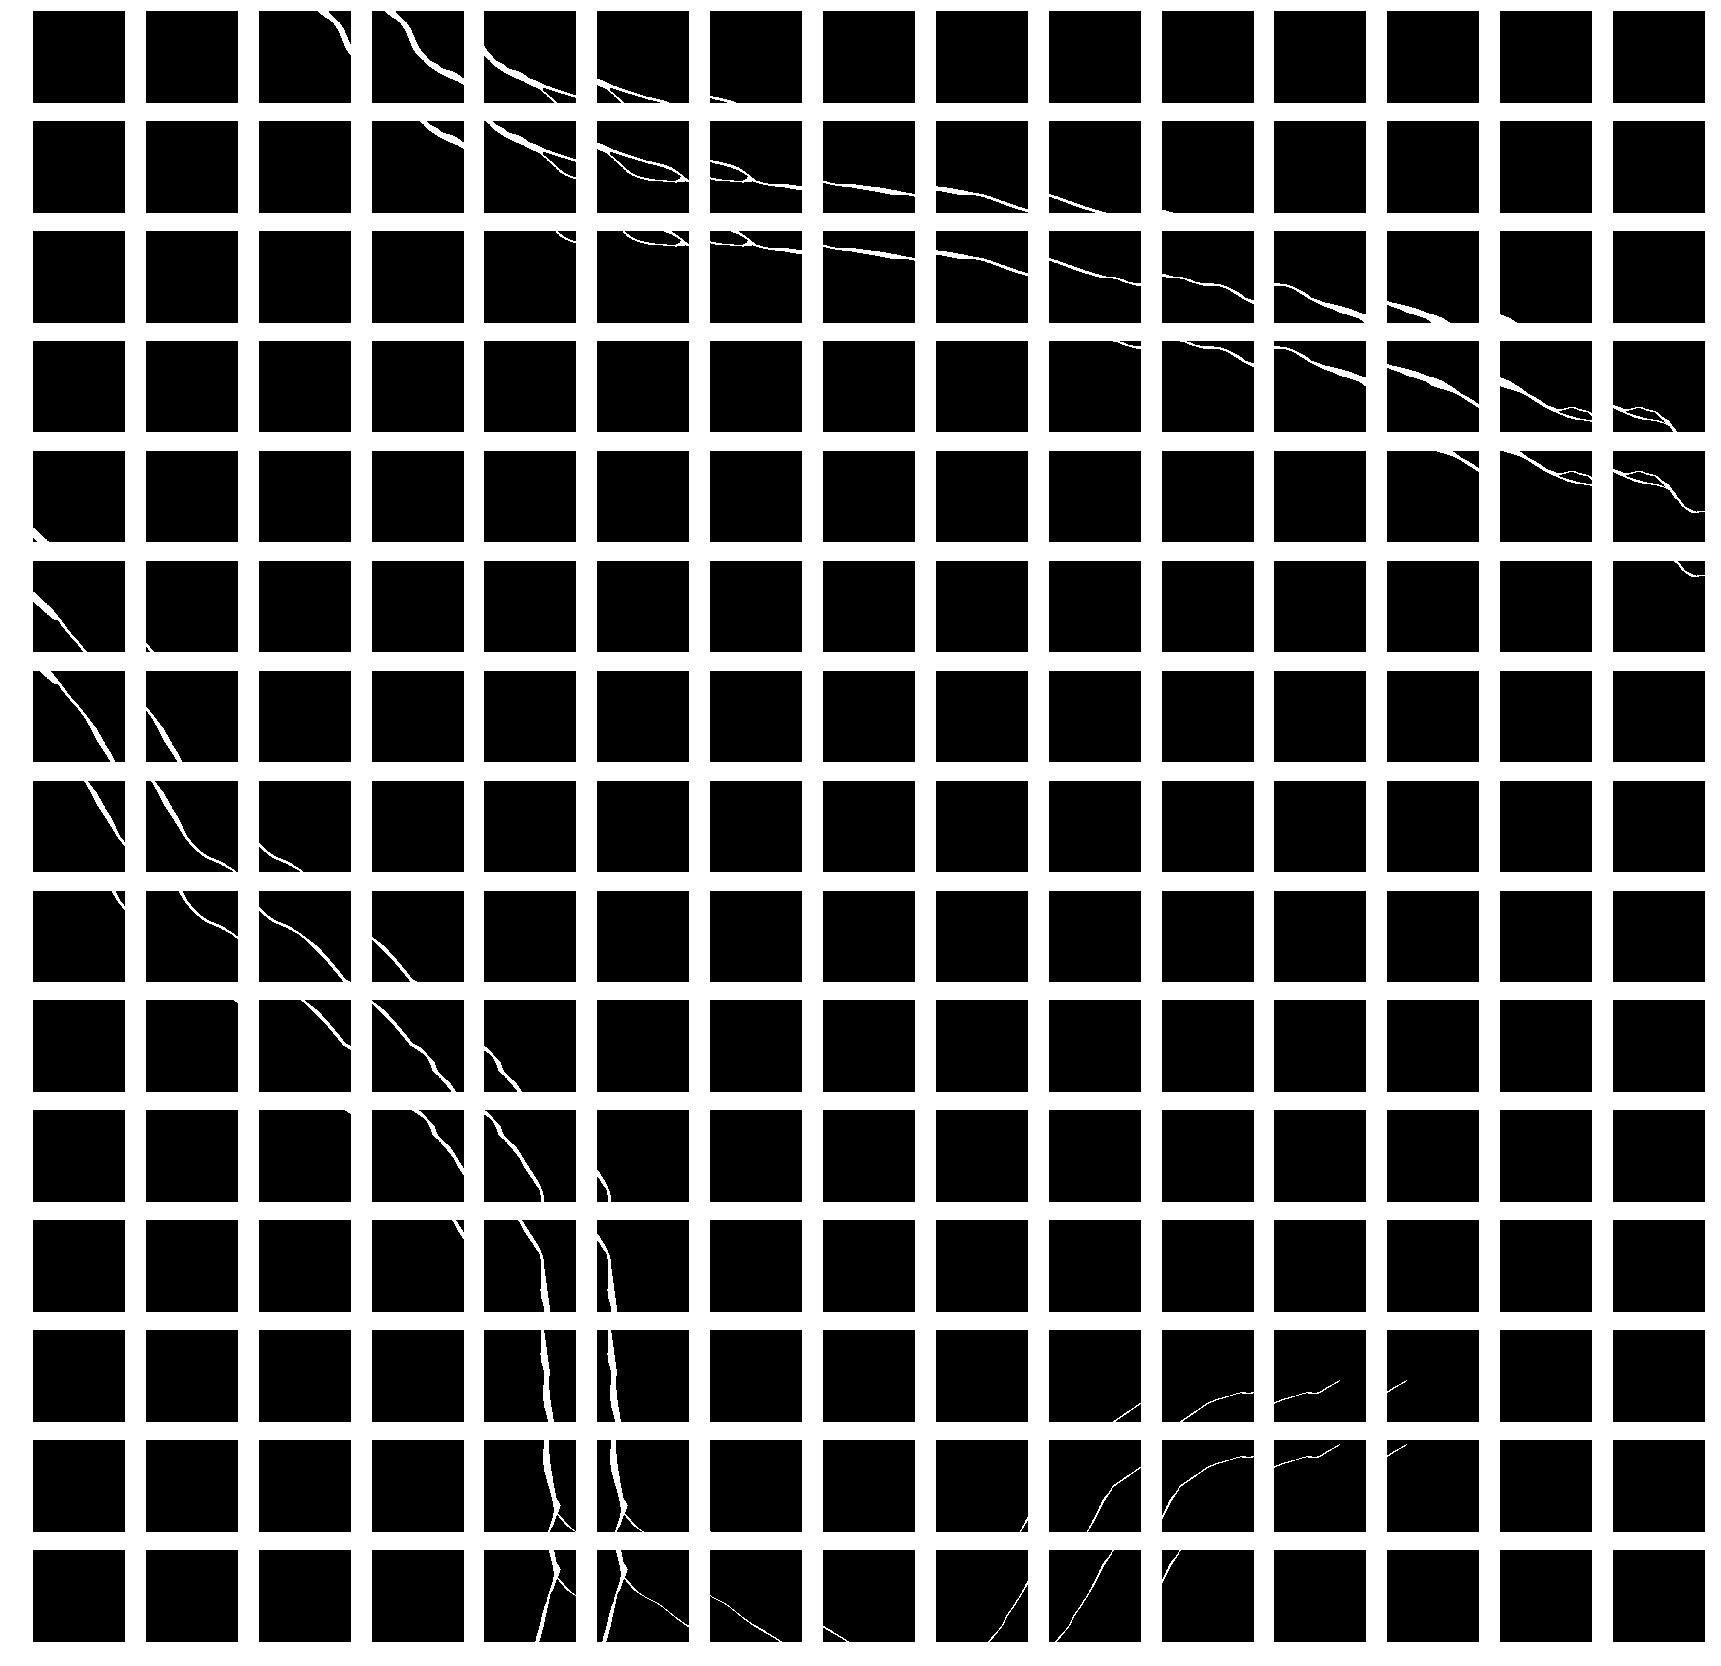

In [34]:
if PLOT:
    import matplotlib.pyplot as plt
    %matplotlib inline

    fig, axes = plt.subplots(i_max, i_max, figsize=(i_max*2, i_max*2))
    jj = 0
    for i in range(0, i_max):
        for j in range(0, i_max):
            axes[i, j].imshow(arr_mask[jj], cmap='gray')
            axes[i, j].set_axis_off()
            jj += 1

# Save dataset with pickle

In [ ]:
import pickle

with open(r"dataset/kaggle/" + DATASET_X_NAME, "wb") as output_file:
    pickle.dump(arr_img, output_file)
        
with open(r"dataset/kaggle/" + DATASET_Y_NAME, "wb") as output_file:
    pickle.dump(arr_mask, output_file)